In [1]:
import numpy as np
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from itertools import product

# --- 1) Load data ---
X = np.load("Data/X_train.npy")  # (700,6)
y = np.load("Data/Y_train.npy")  # (700,)

# --- 2) Outlier detection ---
X_scaled = StandardScaler().fit_transform(X)

# Z-score
zs = np.abs(zscore(X_scaled))
z_thresh = 3.0
outlier_mask_z = (zs > z_thresh).any(axis=1)

# IsolationForest
iso = IsolationForest(contamination=0.01, random_state=42)
is_outlier_iso = iso.fit_predict(X_scaled) == -1

# Combine
outlier_union = outlier_mask_z | is_outlier_iso
final_mask = ~outlier_union   # keep only non-outliers

X_clean = X[final_mask]
y_clean = y[final_mask]

print("Outliers removed:", outlier_union.sum())
print("Clean data shape:", X_clean.shape, y_clean.shape)

# --- 3) Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=200, random_state=19, shuffle=True
)

# --- 4) Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- 5) RBF transform function ---
def rbf_transform(X, centers, sigma):
    diff = X[:, np.newaxis, :] - centers[np.newaxis, :, :]
    return np.exp(-np.sum(diff**2, axis=2) / (2*sigma**2))

# --- 6) Hyperparameter grids ---
sigma_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]
n_centers_list = [150, 175, 200, 225, 250]
alpha_list = [0.0005, 0.00075, 0.001, 0.005, 0.01]

# --- 7) K-Fold CV for hyperparameter search ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_r2 = -np.inf
best_params = None
results = []

for sigma, n_centers, alpha in product(sigma_list, n_centers_list, alpha_list):
    r2_scores = []
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # KMeans centers on fold
        kmeans = KMeans(n_clusters=n_centers, random_state=42)
        kmeans.fit(X_tr)
        centers = kmeans.cluster_centers_

        # RBF transformation
        X_tr_rbf = rbf_transform(X_tr, centers, sigma)
        X_val_rbf = rbf_transform(X_val, centers, sigma)

        # Ridge regression
        model = Ridge(alpha=alpha)
        model.fit(X_tr_rbf, y_tr)

        # Validation
        y_val_pred = model.predict(X_val_rbf)
        r2_scores.append(r2_score(y_val, y_val_pred))

    mean_r2 = np.mean(r2_scores)
    results.append({'sigma': sigma, 'n_centers': n_centers, 'alpha': alpha, 'mean_r2': mean_r2})
    print(sigma, n_centers, alpha, mean_r2)

    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_params = {'sigma': sigma, 'n_centers': n_centers, 'alpha': alpha}

print("Best CV R2:", best_r2)
print("Best hyperparameters:", best_params)

# --- 8) Train final model on all clean training data ---
kmeans_final = KMeans(n_clusters=best_params['n_centers'], random_state=42).fit(X_train_scaled)
X_train_rbf_final = rbf_transform(X_train_scaled, kmeans_final.cluster_centers_, best_params['sigma'])
X_test_rbf_final  = rbf_transform(X_test_scaled,  kmeans_final.cluster_centers_, best_params['sigma'])

final_model = Ridge(alpha=best_params['alpha']).fit(X_train_rbf_final, y_train)
y_test_pred = final_model.predict(X_test_rbf_final)
print("Final Test R2:", r2_score(y_test, y_test_pred))


Outliers removed: 10
Clean data shape: (690, 6) (690,)
0.5 150 0.0005 0.6168711370879422
0.5 150 0.00075 0.6168539086412246
0.5 150 0.001 0.6168365039409773
0.5 150 0.005 0.6165355684274758
0.5 150 0.01 0.6161072151097533
0.5 175 0.0005 0.6385774894352417
0.5 175 0.00075 0.6385907587586844
0.5 175 0.001 0.6386033880796209
0.5 175 0.005 0.6387259359186002
0.5 175 0.01 0.6387031817150091
0.5 200 0.0005 0.6488570268017855
0.5 200 0.00075 0.6488892379260282
0.5 200 0.001 0.6489201718130393
0.5 200 0.005 0.6492631025636217
0.5 200 0.01 0.649381702042875
0.5 225 0.0005 0.6585329300814173
0.5 225 0.00075 0.6586033277600396
0.5 225 0.001 0.6586702682820166
0.5 225 0.005 0.6593635796117531
0.5 225 0.01 0.6595716155544272
0.5 250 0.0005 0.6677527362752537
0.5 250 0.00075 0.6679902799936913
0.5 250 0.001 0.6682162941911398
0.5 250 0.005 0.6706800137776187
0.5 250 0.01 0.6720188338229276
1.0 150 0.0005 0.9136012146390573
1.0 150 0.00075 0.9136034229796323
1.0 150 0.001 0.9135971980581777
1.0 150 0

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Convert to torch Tensors
X_train_t = torch.from_numpy(X_train_scaled).float()
y_train_t = torch.from_numpy(y_train).float().view(-1,1)
X_test_t  = torch.from_numpy(X_test_scaled).float()
y_test_t  = torch.from_numpy(y_test).float().view(-1,1)

# Dataset / DataLoader helper
def make_loader(X, y, batch_size=32, shuffle=True):
    ds = TensorDataset(X, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

# Define a regression neural network
class RegressionNet(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        # output layer
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

# Training function
def train_model(model, loader_train, loader_valid, lr=1e-3, weight_decay=0.0, n_epochs=100, patience=10):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
    best_val_loss = float('inf')
    best_state = None
    epochs_no_improve = 0
    
    for epoch in range(n_epochs):
        model.train()
        for xb, yb in loader_train:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # validation
        if loader_valid is not None:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for xb, yb in loader_valid:
                    val_losses.append(loss_fn(model(xb), yb).item())
            avg_val = float(np.mean(val_losses))
            # Early stopping
            if avg_val < best_val_loss - 1e-6:
                best_val_loss = avg_val
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break
    
    # load best state
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val_loss

# Example hyperparameter search via KFold
from sklearn.model_selection import KFold

def cv_nn(X, y, hidden_dims, lr, weight_decay, n_epochs=100, batch_size=32):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_losses = []
    for train_idx, val_idx in kf.split(X):
        X_tr = X[train_idx]
        y_tr = y[train_idx]
        X_va = X[val_idx]
        y_va = y[val_idx]
        # Convert to torch
        X_tr_t = torch.from_numpy(X_tr).float()
        y_tr_t = torch.from_numpy(y_tr).float().view(-1,1)
        X_va_t = torch.from_numpy(X_va).float()
        y_va_t = torch.from_numpy(y_va).float().view(-1,1)
        dl_tr = make_loader(X_tr_t, y_tr_t, batch_size=batch_size, shuffle=True)
        dl_va = make_loader(X_va_t, y_va_t, batch_size=batch_size, shuffle=False)
        model = RegressionNet(input_dim=X.shape[1], hidden_dims=hidden_dims)
        model, val_loss = train_model(model, dl_tr, dl_va, lr=lr, weight_decay=weight_decay, n_epochs=n_epochs)
        val_losses.append(val_loss)
    return np.mean(val_losses)

# You can grid-search over hidden_dims, lr, weight_decay, etc.
hidden_options = [[32,16], [64,32,16], [128,64]]
lr_list = [1e-3, 5e-4, 1e-4]
wd_list = [0.0, 1e-4, 1e-5]

best = None
best_params = None
for hidden in hidden_options:
    for lr in lr_list:
        for wd in wd_list:
            val_loss = cv_nn(X_train_scaled, y_train, hidden, lr, wd, n_epochs=100, batch_size=32)
            print("hidden", hidden, "lr", lr, "wd", wd, "-> val loss", val_loss)
            if best is None or val_loss < best:
                best = val_loss
                best_params = {'hidden': hidden, 'lr': lr, 'wd': wd}

print("Best CV params:", best_params)

# Train final model on full training data and evaluate test
dl_train_full = make_loader(X_train_t, y_train_t, batch_size=32, shuffle=True)
# (Optionally you could set aside a small validation split for early stopping)
model = RegressionNet(input_dim=X_train_scaled.shape[1], hidden_dims=best_params['hidden'])
model, _ = train_model(model, dl_train_full, loader_valid=None,  # no validation here
                       lr=best_params['lr'], weight_decay=best_params['wd'], n_epochs=200, patience=20)

model.eval()
with torch.no_grad():
    y_test_pred_t = model(X_test_t).view(-1).cpu().numpy()
from sklearn.metrics import r2_score
print("Test R2 (NN):", r2_score(y_test, y_test_pred_t))


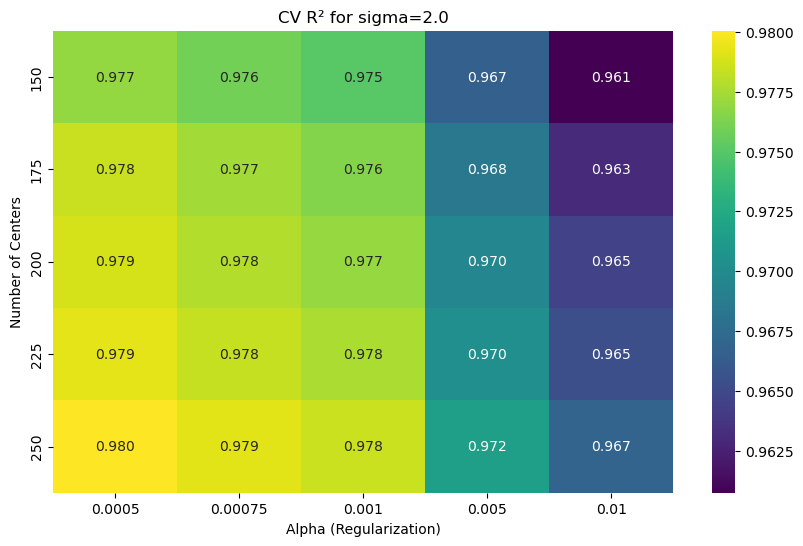

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Converter lista de resultados em DataFrame
df_results = pd.DataFrame(results)

# Agora podemos fazer o subset para o melhor sigma
best_sigma = best_params['sigma']
subset = df_results[df_results['sigma'] == best_sigma]

# Criar pivot table para heatmap
pivot = subset.pivot(index='n_centers', columns='alpha', values='mean_r2')

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
plt.title(f"CV R² for sigma={best_sigma}")
plt.xlabel("Alpha (Regularization)")
plt.ylabel("Number of Centers")
plt.show()
